In [ ]:
!pip install tqdm


[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: python -m pip install --upgrade pip


In [ ]:
!pip install matplotlib


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 44.5 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 101.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 313.1 MB/s eta 0:00:00

[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: python -m pip install --upgrade pip


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
from tqdm import tqdm
import matplotlib.pyplot as plt
import os

In [ ]:
import zipfile

zip_path = "PartB_DFU_Dataset_Infection.zip"  # Replace with the correct filename
extract_to = "dataset"  # Folder where files will be extracted

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print("Extraction completed!")

Extraction completed!


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
dataset_path = "dataset/PartB_DFU_Dataset"  # Change this to your dataset path
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [ ]:
dataset = datasets.ImageFolder(root=dataset_path, transform=transform)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

# Function to Display Images
def show_images(images):
    img_grid = make_grid(images[:16], normalize=True)
    plt.figure(figsize=(8, 8))
    plt.imshow(img_grid.permute(1, 2, 0))
    plt.axis("off")
    plt.show()

# Print class names
print("Classes:", dataset.classes)
print("Number of images:", len(dataset))

Classes: ['Infection']
Number of images: 5890


In [ ]:

# ----------------------
# Hybrid Generator (LSTM + CNN)
# ----------------------
class HybridGenerator(nn.Module):
    def __init__(self, latent_dim, sequence_length):
        super(HybridGenerator, self).__init__()
        self.lstm = nn.LSTM(latent_dim, latent_dim, num_layers=2, batch_first=True)
        self.sequence_length = sequence_length

        self.cnn = nn.Sequential(
            nn.Linear(latent_dim * sequence_length, 256 * 8 * 8),
            nn.ReLU(),
            nn.Unflatten(1, (256, 8, 8)),

            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),

            nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        batch_size = x.size(0)
        x, _ = self.lstm(x)  # LSTM output
        x = x.reshape(batch_size, -1)  # Flatten for CNN
        return self.cnn(x)

In [ ]:
# ----------------------
# Discriminator (Unchanged)
# ----------------------
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(256, 1, kernel_size=4, stride=1, padding=0),
            nn.Flatten(),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)


In [ ]:

# ----------------------
# Gradient Penalty
# ----------------------
def gradient_penalty(disc, real, fake):
    alpha = torch.rand(real.size(0), 1, 1, 1).to(device)
    interpolated = (alpha * real + (1 - alpha) * fake).requires_grad_(True)
    mixed_scores = disc(interpolated)
    grad_outputs = torch.ones_like(mixed_scores)

    gradients = torch.autograd.grad(
        outputs=mixed_scores,
        inputs=interpolated,
        grad_outputs=grad_outputs,
        create_graph=True,
        retain_graph=True,
        only_inputs=True
    )[0]

    gradients = gradients.view(gradients.size(0), -1)
    gradient_norm = gradients.norm(2, dim=1)
    return ((gradient_norm - 1) ** 2).mean()

Epoch 1/200: 100%|██████████| 369/369 [01:05<00:00,  5.68it/s]


Epoch [1/200] | D Loss: 0.0030 | G Loss: -0.5662


Epoch 2/200: 100%|██████████| 369/369 [00:55<00:00,  6.62it/s]


Epoch [2/200] | D Loss: 0.3111 | G Loss: -0.3434


Epoch 3/200: 100%|██████████| 369/369 [00:44<00:00,  8.30it/s]


Epoch [3/200] | D Loss: -0.0712 | G Loss: -0.4995


Epoch 4/200: 100%|██████████| 369/369 [00:42<00:00,  8.59it/s]


Epoch [4/200] | D Loss: -0.0649 | G Loss: -0.4776


Epoch 5/200: 100%|██████████| 369/369 [00:47<00:00,  7.74it/s]


Epoch [5/200] | D Loss: -0.0491 | G Loss: -0.5320


Epoch 6/200: 100%|██████████| 369/369 [00:41<00:00,  8.89it/s]


Epoch [6/200] | D Loss: 0.0736 | G Loss: -0.5111


Epoch 7/200: 100%|██████████| 369/369 [00:38<00:00,  9.71it/s]


Epoch [7/200] | D Loss: -0.0256 | G Loss: -0.4125


Epoch 8/200: 100%|██████████| 369/369 [00:52<00:00,  7.06it/s]


Epoch [8/200] | D Loss: 0.6980 | G Loss: -0.5762


Epoch 9/200: 100%|██████████| 369/369 [00:59<00:00,  6.20it/s]


Epoch [9/200] | D Loss: -0.0649 | G Loss: -0.3599


Epoch 10/200: 100%|██████████| 369/369 [00:37<00:00,  9.74it/s]


Epoch [10/200] | D Loss: -0.1249 | G Loss: -0.4259


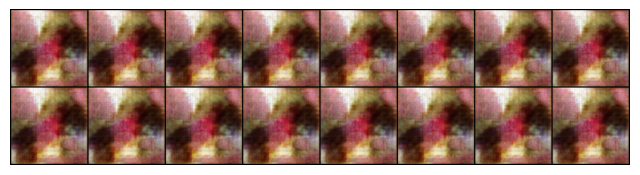

Epoch 11/200: 100%|██████████| 369/369 [00:39<00:00,  9.38it/s]


Epoch [11/200] | D Loss: 0.0444 | G Loss: -0.5195


Epoch 12/200: 100%|██████████| 369/369 [00:40<00:00,  9.14it/s]


Epoch [12/200] | D Loss: -0.0136 | G Loss: -0.5789


Epoch 13/200: 100%|██████████| 369/369 [00:37<00:00,  9.73it/s]


Epoch [13/200] | D Loss: 0.1140 | G Loss: -0.4846


Epoch 14/200: 100%|██████████| 369/369 [00:45<00:00,  8.09it/s]


Epoch [14/200] | D Loss: -0.0692 | G Loss: -0.4978


Epoch 15/200: 100%|██████████| 369/369 [00:57<00:00,  6.40it/s]


Epoch [15/200] | D Loss: -0.0478 | G Loss: -0.4704


Epoch 16/200: 100%|██████████| 369/369 [00:45<00:00,  8.14it/s]


Epoch [16/200] | D Loss: -0.0246 | G Loss: -0.4875


Epoch 17/200: 100%|██████████| 369/369 [00:41<00:00,  8.91it/s]


Epoch [17/200] | D Loss: 0.2054 | G Loss: -0.4524


Epoch 18/200: 100%|██████████| 369/369 [00:55<00:00,  6.66it/s]


Epoch [18/200] | D Loss: -0.0444 | G Loss: -0.5870


Epoch 19/200: 100%|██████████| 369/369 [00:55<00:00,  6.63it/s]


Epoch [19/200] | D Loss: -0.0306 | G Loss: -0.5028


Epoch 20/200: 100%|██████████| 369/369 [00:37<00:00,  9.79it/s]


Epoch [20/200] | D Loss: -0.0467 | G Loss: -0.5938


Epoch 21/200: 100%|██████████| 369/369 [00:58<00:00,  6.35it/s]


Epoch [21/200] | D Loss: -0.0419 | G Loss: -0.5544


Epoch 22/200: 100%|██████████| 369/369 [00:51<00:00,  7.14it/s]


Epoch [22/200] | D Loss: 0.0507 | G Loss: -0.4760


Epoch 23/200: 100%|██████████| 369/369 [00:37<00:00,  9.76it/s]


Epoch [23/200] | D Loss: 0.0025 | G Loss: -0.6308


Epoch 24/200: 100%|██████████| 369/369 [00:48<00:00,  7.61it/s]


Epoch [24/200] | D Loss: -0.0118 | G Loss: -0.6019


Epoch 25/200: 100%|██████████| 369/369 [00:55<00:00,  6.61it/s]


Epoch [25/200] | D Loss: -0.0009 | G Loss: -0.5784


Epoch 26/200: 100%|██████████| 369/369 [00:44<00:00,  8.22it/s]


Epoch [26/200] | D Loss: -0.0022 | G Loss: -0.5204


Epoch 27/200: 100%|██████████| 369/369 [00:37<00:00,  9.95it/s]


Epoch [27/200] | D Loss: -0.0231 | G Loss: -0.5276


Epoch 28/200: 100%|██████████| 369/369 [00:40<00:00,  9.07it/s]


Epoch [28/200] | D Loss: 0.0585 | G Loss: -0.5084


Epoch 29/200: 100%|██████████| 369/369 [00:39<00:00,  9.27it/s]


Epoch [29/200] | D Loss: -0.0001 | G Loss: -0.5768


Epoch 30/200: 100%|██████████| 369/369 [00:37<00:00,  9.78it/s]


Epoch [30/200] | D Loss: -0.0279 | G Loss: -0.2476


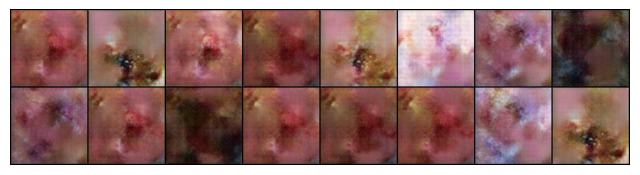

Epoch 31/200: 100%|██████████| 369/369 [00:46<00:00,  7.90it/s]


Epoch [31/200] | D Loss: 0.0425 | G Loss: -0.5485


Epoch 32/200: 100%|██████████| 369/369 [01:02<00:00,  5.92it/s]


Epoch [32/200] | D Loss: -0.0167 | G Loss: -0.6002


Epoch 33/200: 100%|██████████| 369/369 [00:44<00:00,  8.22it/s]


Epoch [33/200] | D Loss: 0.1355 | G Loss: -0.5201


Epoch 34/200: 100%|██████████| 369/369 [00:56<00:00,  6.51it/s]


Epoch [34/200] | D Loss: 0.0037 | G Loss: -0.4950


Epoch 35/200: 100%|██████████| 369/369 [00:53<00:00,  6.87it/s]


Epoch [35/200] | D Loss: 0.0253 | G Loss: -0.5884


Epoch 36/200: 100%|██████████| 369/369 [00:37<00:00,  9.85it/s]


Epoch [36/200] | D Loss: 0.0030 | G Loss: -0.6001


Epoch 37/200: 100%|██████████| 369/369 [00:51<00:00,  7.15it/s]


Epoch [37/200] | D Loss: -0.0060 | G Loss: -0.5474


Epoch 38/200: 100%|██████████| 369/369 [00:57<00:00,  6.45it/s]


Epoch [38/200] | D Loss: 0.3805 | G Loss: -0.6233


Epoch 39/200: 100%|██████████| 369/369 [00:36<00:00, 10.05it/s]


Epoch [39/200] | D Loss: -0.0028 | G Loss: -0.5798


Epoch 40/200: 100%|██████████| 369/369 [00:55<00:00,  6.67it/s]

Epoch [40/200] | D Loss: -0.0116 | G Loss: -0.5154


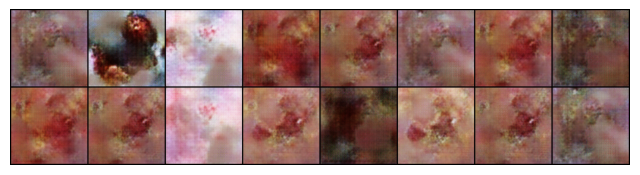

Epoch 41/200: 100%|██████████| 369/369 [00:58<00:00,  6.26it/s]


Epoch [41/200] | D Loss: -0.0153 | G Loss: -0.5176


Epoch 42/200: 100%|██████████| 369/369 [00:52<00:00,  7.07it/s]


Epoch [42/200] | D Loss: -0.0227 | G Loss: -0.5343


Epoch 43/200: 100%|██████████| 369/369 [00:58<00:00,  6.29it/s]


Epoch [43/200] | D Loss: -0.0458 | G Loss: -0.6743


Epoch 44/200: 100%|██████████| 369/369 [00:37<00:00,  9.89it/s]


Epoch [44/200] | D Loss: -0.0153 | G Loss: -0.4867


Epoch 45/200: 100%|██████████| 369/369 [00:57<00:00,  6.39it/s]


Epoch [45/200] | D Loss: -0.0397 | G Loss: -0.5286


Epoch 46/200: 100%|██████████| 369/369 [00:58<00:00,  6.34it/s]


Epoch [46/200] | D Loss: 0.0078 | G Loss: -0.5062


Epoch 47/200: 100%|██████████| 369/369 [00:47<00:00,  7.70it/s]


Epoch [47/200] | D Loss: -0.0352 | G Loss: -0.5049


Epoch 48/200: 100%|██████████| 369/369 [00:57<00:00,  6.44it/s]


Epoch [48/200] | D Loss: -0.0473 | G Loss: -0.6163


Epoch 49/200: 100%|██████████| 369/369 [00:45<00:00,  8.05it/s]


Epoch [49/200] | D Loss: -0.0439 | G Loss: -0.5017


Epoch 50/200: 100%|██████████| 369/369 [00:39<00:00,  9.42it/s]


Epoch [50/200] | D Loss: 0.0078 | G Loss: -0.5785


Epoch 51/200: 100%|██████████| 369/369 [00:38<00:00,  9.48it/s]


Epoch [51/200] | D Loss: -0.0129 | G Loss: -0.4762


Epoch 52/200: 100%|██████████| 369/369 [00:40<00:00,  9.13it/s]


Epoch [52/200] | D Loss: 0.0287 | G Loss: -0.6425


Epoch 53/200: 100%|██████████| 369/369 [00:40<00:00,  9.13it/s]


Epoch [53/200] | D Loss: -0.0245 | G Loss: -0.5916


Epoch 54/200: 100%|██████████| 369/369 [00:39<00:00,  9.27it/s]


Epoch [54/200] | D Loss: 0.0421 | G Loss: -0.4928


Epoch 55/200: 100%|██████████| 369/369 [00:39<00:00,  9.41it/s]


Epoch [55/200] | D Loss: 0.3099 | G Loss: -0.7351


Epoch 56/200: 100%|██████████| 369/369 [00:39<00:00,  9.28it/s]


Epoch [56/200] | D Loss: -0.0190 | G Loss: -0.5194


Epoch 57/200: 100%|██████████| 369/369 [00:40<00:00,  9.18it/s]


Epoch [57/200] | D Loss: -0.0355 | G Loss: -0.5129


Epoch 58/200: 100%|██████████| 369/369 [00:42<00:00,  8.75it/s]


Epoch [58/200] | D Loss: -0.0356 | G Loss: -0.6216


Epoch 59/200: 100%|██████████| 369/369 [00:40<00:00,  9.17it/s]


Epoch [59/200] | D Loss: -0.0108 | G Loss: -0.5053


Epoch 60/200: 100%|██████████| 369/369 [00:38<00:00,  9.69it/s]


Epoch [60/200] | D Loss: -0.0374 | G Loss: -0.5602


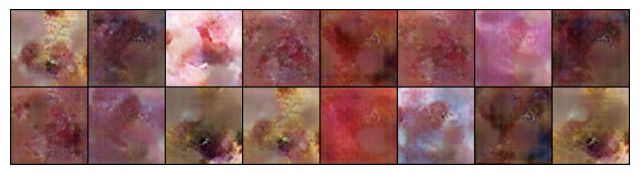

Epoch 61/200: 100%|██████████| 369/369 [00:38<00:00,  9.64it/s]


Epoch [61/200] | D Loss: -0.0370 | G Loss: -0.5010


Epoch 62/200: 100%|██████████| 369/369 [00:43<00:00,  8.52it/s]


Epoch [62/200] | D Loss: -0.0029 | G Loss: -0.6076


Epoch 63/200: 100%|██████████| 369/369 [00:38<00:00,  9.61it/s]


Epoch [63/200] | D Loss: 0.0103 | G Loss: -0.4156


Epoch 64/200: 100%|██████████| 369/369 [00:37<00:00,  9.77it/s]


Epoch [64/200] | D Loss: -0.0162 | G Loss: -0.5818


Epoch 65/200: 100%|██████████| 369/369 [00:40<00:00,  9.11it/s]


Epoch [65/200] | D Loss: -0.0437 | G Loss: -0.6445


Epoch 66/200: 100%|██████████| 369/369 [00:39<00:00,  9.27it/s]


Epoch [66/200] | D Loss: -0.0202 | G Loss: -0.5375


Epoch 67/200: 100%|██████████| 369/369 [00:57<00:00,  6.42it/s]


Epoch [67/200] | D Loss: -0.0836 | G Loss: -0.4219


Epoch 68/200: 100%|██████████| 369/369 [00:58<00:00,  6.34it/s]


Epoch [68/200] | D Loss: -0.0145 | G Loss: -0.5214


Epoch 69/200: 100%|██████████| 369/369 [00:38<00:00,  9.59it/s]


Epoch [69/200] | D Loss: -0.0164 | G Loss: -0.6088


Epoch 70/200: 100%|██████████| 369/369 [00:41<00:00,  8.81it/s]


Epoch [70/200] | D Loss: -0.0873 | G Loss: -0.6069


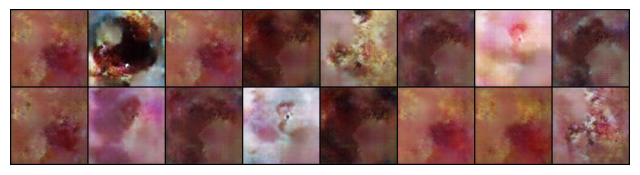

Epoch 71/200: 100%|██████████| 369/369 [00:40<00:00,  9.02it/s]


Epoch [71/200] | D Loss: -0.0324 | G Loss: -0.4845


Epoch 72/200: 100%|██████████| 369/369 [00:38<00:00,  9.68it/s]


Epoch [72/200] | D Loss: -0.0304 | G Loss: -0.5818


Epoch 73/200: 100%|██████████| 369/369 [00:44<00:00,  8.26it/s]


Epoch [73/200] | D Loss: -0.0093 | G Loss: -0.5376


Epoch 74/200: 100%|██████████| 369/369 [01:01<00:00,  6.05it/s]


Epoch [74/200] | D Loss: -0.1048 | G Loss: -0.5471


Epoch 75/200: 100%|██████████| 369/369 [00:53<00:00,  6.87it/s]


Epoch [75/200] | D Loss: -0.0806 | G Loss: -0.5650


Epoch 76/200: 100%|██████████| 369/369 [00:38<00:00,  9.66it/s]


Epoch [76/200] | D Loss: -0.0152 | G Loss: -0.4532


Epoch 77/200: 100%|██████████| 369/369 [00:58<00:00,  6.30it/s]


Epoch [77/200] | D Loss: -0.0142 | G Loss: -0.5952


Epoch 78/200: 100%|██████████| 369/369 [01:00<00:00,  6.13it/s]


Epoch [78/200] | D Loss: 0.0094 | G Loss: -0.5496


Epoch 79/200: 100%|██████████| 369/369 [00:38<00:00,  9.54it/s]


Epoch [79/200] | D Loss: -0.0058 | G Loss: -0.6095


Epoch 80/200: 100%|██████████| 369/369 [00:44<00:00,  8.32it/s]

Epoch [80/200] | D Loss: -0.0077 | G Loss: -0.5804


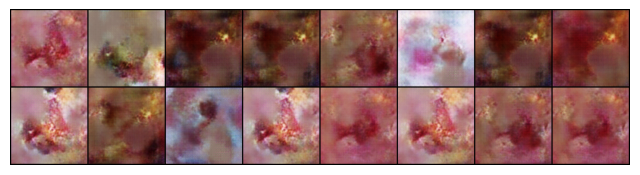

Epoch 81/200: 100%|██████████| 369/369 [01:00<00:00,  6.14it/s]


Epoch [81/200] | D Loss: -0.1083 | G Loss: -0.5485


Epoch 82/200: 100%|██████████| 369/369 [00:46<00:00,  7.97it/s]


Epoch [82/200] | D Loss: -0.0700 | G Loss: -0.5321


Epoch 83/200: 100%|██████████| 369/369 [00:37<00:00,  9.87it/s]


Epoch [83/200] | D Loss: -0.0617 | G Loss: -0.5850


Epoch 84/200: 100%|██████████| 369/369 [00:54<00:00,  6.73it/s]


Epoch [84/200] | D Loss: -0.0110 | G Loss: -0.5824


Epoch 85/200: 100%|██████████| 369/369 [01:00<00:00,  6.12it/s]


Epoch [85/200] | D Loss: 0.0038 | G Loss: -0.6459


Epoch 86/200: 100%|██████████| 369/369 [00:38<00:00,  9.68it/s]


Epoch [86/200] | D Loss: -0.0280 | G Loss: -0.5399


Epoch 87/200: 100%|██████████| 369/369 [00:42<00:00,  8.75it/s]


Epoch [87/200] | D Loss: 0.0307 | G Loss: -0.5918


Epoch 88/200: 100%|██████████| 369/369 [00:37<00:00,  9.76it/s]


Epoch [88/200] | D Loss: -0.0129 | G Loss: -0.5432


Epoch 89/200: 100%|██████████| 369/369 [00:41<00:00,  8.98it/s]


Epoch [89/200] | D Loss: -0.0725 | G Loss: -0.5323


Epoch 90/200: 100%|██████████| 369/369 [00:59<00:00,  6.19it/s]


Epoch [90/200] | D Loss: -0.0478 | G Loss: -0.5253


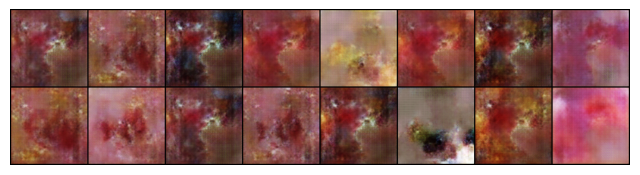

Epoch 91/200: 100%|██████████| 369/369 [00:49<00:00,  7.46it/s]


Epoch [91/200] | D Loss: -0.0983 | G Loss: -0.6072


Epoch 92/200: 100%|██████████| 369/369 [00:38<00:00,  9.61it/s]


Epoch [92/200] | D Loss: -0.0412 | G Loss: -0.5914


Epoch 93/200: 100%|██████████| 369/369 [00:49<00:00,  7.46it/s]


Epoch [93/200] | D Loss: 0.0075 | G Loss: -0.7017


Epoch 94/200: 100%|██████████| 369/369 [00:59<00:00,  6.17it/s]


Epoch [94/200] | D Loss: -0.0344 | G Loss: -0.5881


Epoch 95/200: 100%|██████████| 369/369 [00:41<00:00,  8.88it/s]


Epoch [95/200] | D Loss: -0.0354 | G Loss: -0.5126


Epoch 96/200: 100%|██████████| 369/369 [00:37<00:00,  9.89it/s]


Epoch [96/200] | D Loss: 0.0117 | G Loss: -0.5464


Epoch 97/200: 100%|██████████| 369/369 [00:40<00:00,  9.18it/s]


Epoch [97/200] | D Loss: -0.0142 | G Loss: -0.5520


Epoch 98/200: 100%|██████████| 369/369 [00:40<00:00,  9.20it/s]


Epoch [98/200] | D Loss: -0.0135 | G Loss: -0.5866


Epoch 99/200: 100%|██████████| 369/369 [00:37<00:00,  9.71it/s]


Epoch [99/200] | D Loss: 0.0184 | G Loss: -0.5413


Epoch 100/200: 100%|██████████| 369/369 [00:38<00:00,  9.56it/s]

Epoch [100/200] | D Loss: -0.0206 | G Loss: -0.5425


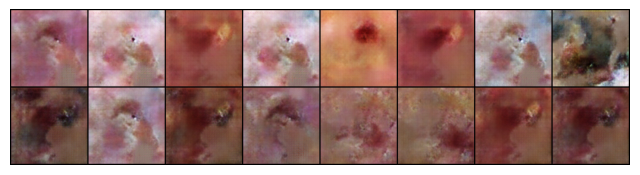

Epoch 101/200: 100%|██████████| 369/369 [00:40<00:00,  9.19it/s]


Epoch [101/200] | D Loss: -0.0026 | G Loss: -0.6464


Epoch 102/200: 100%|██████████| 369/369 [00:38<00:00,  9.66it/s]


Epoch [102/200] | D Loss: -0.0575 | G Loss: -0.5810


Epoch 103/200: 100%|██████████| 369/369 [00:37<00:00,  9.73it/s]


Epoch [103/200] | D Loss: -0.0173 | G Loss: -0.6373


Epoch 104/200: 100%|██████████| 369/369 [00:47<00:00,  7.71it/s]


Epoch [104/200] | D Loss: -0.0530 | G Loss: -0.4816


Epoch 105/200: 100%|██████████| 369/369 [01:00<00:00,  6.15it/s]


Epoch [105/200] | D Loss: -0.0303 | G Loss: -0.4771


Epoch 106/200: 100%|██████████| 369/369 [00:47<00:00,  7.72it/s]


Epoch [106/200] | D Loss: -0.0287 | G Loss: -0.5603


Epoch 107/200: 100%|██████████| 369/369 [00:46<00:00,  8.02it/s]


Epoch [107/200] | D Loss: 0.0816 | G Loss: -0.4768


Epoch 108/200: 100%|██████████| 369/369 [01:01<00:00,  6.03it/s]


Epoch [108/200] | D Loss: -0.0209 | G Loss: -0.4616


Epoch 109/200: 100%|██████████| 369/369 [00:44<00:00,  8.34it/s]


Epoch [109/200] | D Loss: -0.0137 | G Loss: -0.5784


Epoch 110/200: 100%|██████████| 369/369 [01:00<00:00,  6.12it/s]

Epoch [110/200] | D Loss: -0.0576 | G Loss: -0.5417


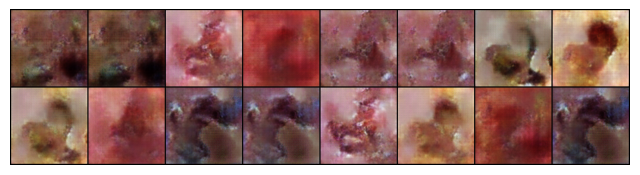

Epoch 111/200: 100%|██████████| 369/369 [00:51<00:00,  7.19it/s]


Epoch [111/200] | D Loss: -0.0565 | G Loss: -0.4933


Epoch 112/200: 100%|██████████| 369/369 [00:48<00:00,  7.59it/s]


Epoch [112/200] | D Loss: -0.0266 | G Loss: -0.4901


Epoch 113/200: 100%|██████████| 369/369 [00:56<00:00,  6.50it/s]


Epoch [113/200] | D Loss: -0.0541 | G Loss: -0.5979


Epoch 114/200: 100%|██████████| 369/369 [00:44<00:00,  8.29it/s]


Epoch [114/200] | D Loss: -0.0196 | G Loss: -0.5586


Epoch 115/200: 100%|██████████| 369/369 [00:52<00:00,  7.07it/s]


Epoch [115/200] | D Loss: -0.0350 | G Loss: -0.4861


Epoch 116/200: 100%|██████████| 369/369 [01:01<00:00,  5.96it/s]


Epoch [116/200] | D Loss: -0.0664 | G Loss: -0.5079


Epoch 117/200: 100%|██████████| 369/369 [00:42<00:00,  8.72it/s]


Epoch [117/200] | D Loss: -0.0408 | G Loss: -0.5248


Epoch 118/200: 100%|██████████| 369/369 [01:05<00:00,  5.61it/s]


Epoch [118/200] | D Loss: -0.0142 | G Loss: -0.5768


Epoch 119/200: 100%|██████████| 369/369 [00:45<00:00,  8.03it/s]


Epoch [119/200] | D Loss: -0.0058 | G Loss: -0.5740


Epoch 120/200: 100%|██████████| 369/369 [01:01<00:00,  6.01it/s]


Epoch [120/200] | D Loss: -0.0167 | G Loss: -0.6302


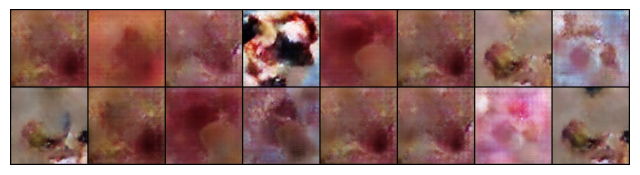

Epoch 121/200: 100%|██████████| 369/369 [00:52<00:00,  7.05it/s]


Epoch [121/200] | D Loss: -0.0612 | G Loss: -0.5933


Epoch 122/200: 100%|██████████| 369/369 [00:57<00:00,  6.47it/s]


Epoch [122/200] | D Loss: -0.0511 | G Loss: -0.4895


Epoch 123/200: 100%|██████████| 369/369 [00:57<00:00,  6.39it/s]


Epoch [123/200] | D Loss: -0.0614 | G Loss: -0.5889


Epoch 124/200: 100%|██████████| 369/369 [00:38<00:00,  9.69it/s]


Epoch [124/200] | D Loss: -0.0118 | G Loss: -0.6510


Epoch 125/200: 100%|██████████| 369/369 [00:38<00:00,  9.53it/s]


Epoch [125/200] | D Loss: 0.0069 | G Loss: -0.4710


Epoch 126/200: 100%|██████████| 369/369 [00:42<00:00,  8.64it/s]


Epoch [126/200] | D Loss: -0.0391 | G Loss: -0.6055


Epoch 127/200: 100%|██████████| 369/369 [00:40<00:00,  9.07it/s]


Epoch [127/200] | D Loss: 0.0062 | G Loss: -0.5625


Epoch 128/200: 100%|██████████| 369/369 [00:39<00:00,  9.34it/s]


Epoch [128/200] | D Loss: -0.0265 | G Loss: -0.5674


Epoch 129/200: 100%|██████████| 369/369 [00:39<00:00,  9.44it/s]


Epoch [129/200] | D Loss: -0.0337 | G Loss: -0.6347


Epoch 130/200: 100%|██████████| 369/369 [00:38<00:00,  9.56it/s]


Epoch [130/200] | D Loss: -0.0819 | G Loss: -0.5468


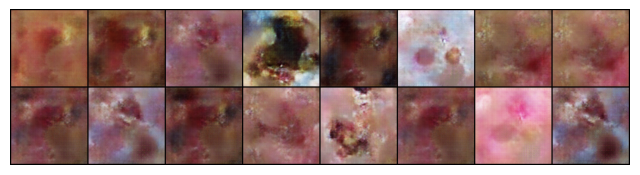

Epoch 131/200: 100%|██████████| 369/369 [00:38<00:00,  9.63it/s]


Epoch [131/200] | D Loss: 0.0209 | G Loss: -0.5585


Epoch 132/200: 100%|██████████| 369/369 [00:37<00:00,  9.93it/s]


Epoch [132/200] | D Loss: -0.0591 | G Loss: -0.5295


Epoch 133/200: 100%|██████████| 369/369 [00:47<00:00,  7.69it/s]


Epoch [133/200] | D Loss: 0.0242 | G Loss: -0.4909


Epoch 134/200: 100%|██████████| 369/369 [00:57<00:00,  6.45it/s]


Epoch [134/200] | D Loss: -0.0147 | G Loss: -0.5540


Epoch 135/200: 100%|██████████| 369/369 [00:45<00:00,  8.16it/s]


Epoch [135/200] | D Loss: -0.0274 | G Loss: -0.5738


Epoch 136/200: 100%|██████████| 369/369 [00:56<00:00,  6.53it/s]


Epoch [136/200] | D Loss: 0.0369 | G Loss: -0.5375


Epoch 137/200: 100%|██████████| 369/369 [00:55<00:00,  6.59it/s]


Epoch [137/200] | D Loss: -0.0176 | G Loss: -0.5777


Epoch 138/200: 100%|██████████| 369/369 [00:39<00:00,  9.41it/s]


Epoch [138/200] | D Loss: -0.0675 | G Loss: -0.5345


Epoch 139/200: 100%|██████████| 369/369 [00:38<00:00,  9.49it/s]


Epoch [139/200] | D Loss: -0.0689 | G Loss: -0.5222


Epoch 140/200: 100%|██████████| 369/369 [00:37<00:00,  9.89it/s]

Epoch [140/200] | D Loss: 0.0149 | G Loss: -0.5499


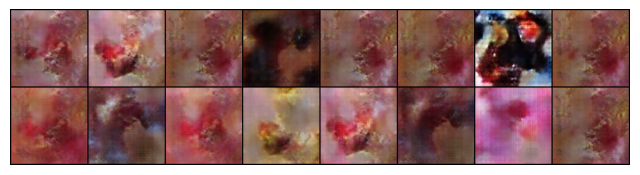

Epoch 141/200: 100%|██████████| 369/369 [00:39<00:00,  9.42it/s]


Epoch [141/200] | D Loss: 0.0230 | G Loss: -0.5006


Epoch 142/200: 100%|██████████| 369/369 [00:40<00:00,  9.16it/s]


Epoch [142/200] | D Loss: -0.0356 | G Loss: -0.6034


Epoch 143/200: 100%|██████████| 369/369 [00:39<00:00,  9.43it/s]


Epoch [143/200] | D Loss: 0.0261 | G Loss: -0.3935


Epoch 144/200: 100%|██████████| 369/369 [00:39<00:00,  9.44it/s]


Epoch [144/200] | D Loss: -0.0345 | G Loss: -0.5170


Epoch 145/200: 100%|██████████| 369/369 [00:38<00:00,  9.58it/s]


Epoch [145/200] | D Loss: -0.0222 | G Loss: -0.5002


Epoch 146/200: 100%|██████████| 369/369 [00:37<00:00,  9.78it/s]


Epoch [146/200] | D Loss: -0.0043 | G Loss: -0.4973


Epoch 147/200: 100%|██████████| 369/369 [00:37<00:00,  9.91it/s]


Epoch [147/200] | D Loss: 0.0181 | G Loss: -0.5285


Epoch 148/200: 100%|██████████| 369/369 [00:38<00:00,  9.55it/s]


Epoch [148/200] | D Loss: 0.0494 | G Loss: -0.4418


Epoch 149/200: 100%|██████████| 369/369 [00:37<00:00,  9.74it/s]


Epoch [149/200] | D Loss: -0.0109 | G Loss: -0.5216


Epoch 150/200: 100%|██████████| 369/369 [00:39<00:00,  9.27it/s]

Epoch [150/200] | D Loss: -0.0233 | G Loss: -0.4354


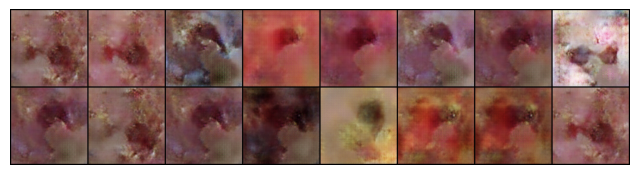

Epoch 151/200: 100%|██████████| 369/369 [00:39<00:00,  9.36it/s]


Epoch [151/200] | D Loss: -0.0250 | G Loss: -0.5269


Epoch 152/200: 100%|██████████| 369/369 [00:41<00:00,  8.92it/s]


Epoch [152/200] | D Loss: -0.0721 | G Loss: -0.4720


Epoch 153/200: 100%|██████████| 369/369 [00:38<00:00,  9.61it/s]


Epoch [153/200] | D Loss: 0.0006 | G Loss: -0.5360


Epoch 154/200: 100%|██████████| 369/369 [00:40<00:00,  9.16it/s]


Epoch [154/200] | D Loss: -0.0389 | G Loss: -0.4617


Epoch 155/200: 100%|██████████| 369/369 [00:37<00:00,  9.89it/s]


Epoch [155/200] | D Loss: 0.0238 | G Loss: -0.5328


Epoch 156/200: 100%|██████████| 369/369 [00:38<00:00,  9.63it/s]


Epoch [156/200] | D Loss: -0.0292 | G Loss: -0.4374


Epoch 157/200: 100%|██████████| 369/369 [00:38<00:00,  9.51it/s]


Epoch [157/200] | D Loss: -0.0270 | G Loss: -0.5063


Epoch 158/200: 100%|██████████| 369/369 [00:37<00:00,  9.71it/s]


Epoch [158/200] | D Loss: -0.0313 | G Loss: -0.6371


Epoch 159/200: 100%|██████████| 369/369 [00:38<00:00,  9.53it/s]


Epoch [159/200] | D Loss: -0.0301 | G Loss: -0.5791


Epoch 160/200: 100%|██████████| 369/369 [00:38<00:00,  9.58it/s]

Epoch [160/200] | D Loss: -0.0146 | G Loss: -0.6001


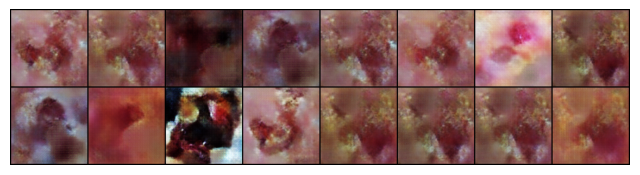

Epoch 161/200: 100%|██████████| 369/369 [00:38<00:00,  9.67it/s]


Epoch [161/200] | D Loss: -0.0274 | G Loss: -0.4972


Epoch 162/200: 100%|██████████| 369/369 [00:36<00:00, 10.00it/s]


Epoch [162/200] | D Loss: -0.0080 | G Loss: -0.5532


Epoch 163/200: 100%|██████████| 369/369 [00:37<00:00,  9.95it/s]


Epoch [163/200] | D Loss: -0.0139 | G Loss: -0.4694


Epoch 164/200: 100%|██████████| 369/369 [00:37<00:00,  9.92it/s]


Epoch [164/200] | D Loss: -0.0358 | G Loss: -0.5815


Epoch 165/200: 100%|██████████| 369/369 [00:38<00:00,  9.66it/s]


Epoch [165/200] | D Loss: -0.0549 | G Loss: -0.4848


Epoch 166/200: 100%|██████████| 369/369 [00:37<00:00,  9.74it/s]


Epoch [166/200] | D Loss: -0.0492 | G Loss: -0.5482


Epoch 167/200: 100%|██████████| 369/369 [00:40<00:00,  9.11it/s]


Epoch [167/200] | D Loss: 0.0213 | G Loss: -0.5560


Epoch 168/200: 100%|██████████| 369/369 [00:37<00:00,  9.76it/s]


Epoch [168/200] | D Loss: 0.0011 | G Loss: -0.4895


Epoch 169/200: 100%|██████████| 369/369 [00:36<00:00, 10.01it/s]


Epoch [169/200] | D Loss: -0.0020 | G Loss: -0.5463


Epoch 170/200: 100%|██████████| 369/369 [00:39<00:00,  9.24it/s]

Epoch [170/200] | D Loss: 0.0122 | G Loss: -0.5818


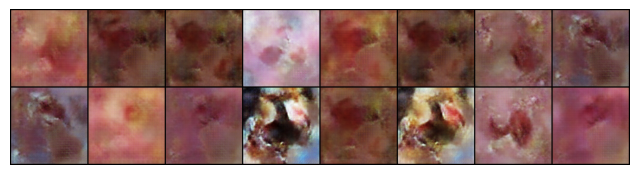

Epoch 171/200: 100%|██████████| 369/369 [00:39<00:00,  9.30it/s]


Epoch [171/200] | D Loss: -0.0183 | G Loss: -0.4045


Epoch 172/200: 100%|██████████| 369/369 [00:37<00:00,  9.81it/s]


Epoch [172/200] | D Loss: -0.0122 | G Loss: -0.5544


Epoch 173/200: 100%|██████████| 369/369 [00:36<00:00, 10.03it/s]


Epoch [173/200] | D Loss: -0.0199 | G Loss: -0.5063


Epoch 174/200: 100%|██████████| 369/369 [00:37<00:00,  9.92it/s]


Epoch [174/200] | D Loss: -0.0596 | G Loss: -0.5734


Epoch 175/200: 100%|██████████| 369/369 [00:37<00:00,  9.87it/s]


Epoch [175/200] | D Loss: -0.0523 | G Loss: -0.6057


Epoch 176/200: 100%|██████████| 369/369 [00:38<00:00,  9.61it/s]


Epoch [176/200] | D Loss: -0.0019 | G Loss: -0.6116


Epoch 177/200: 100%|██████████| 369/369 [00:37<00:00,  9.84it/s]


Epoch [177/200] | D Loss: -0.0287 | G Loss: -0.4768


Epoch 178/200: 100%|██████████| 369/369 [00:36<00:00,  9.98it/s]


Epoch [178/200] | D Loss: -0.0213 | G Loss: -0.5339


Epoch 179/200: 100%|██████████| 369/369 [00:36<00:00, 10.00it/s]


Epoch [179/200] | D Loss: 0.0130 | G Loss: -0.4600


Epoch 180/200: 100%|██████████| 369/369 [00:37<00:00,  9.84it/s]


Epoch [180/200] | D Loss: 0.0373 | G Loss: -0.5378


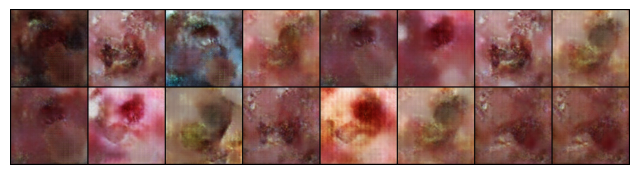

Epoch 181/200: 100%|██████████| 369/369 [00:37<00:00,  9.90it/s]


Epoch [181/200] | D Loss: -0.0322 | G Loss: -0.4978


Epoch 182/200: 100%|██████████| 369/369 [00:37<00:00,  9.91it/s]


Epoch [182/200] | D Loss: -0.0228 | G Loss: -0.5345


Epoch 183/200: 100%|██████████| 369/369 [00:37<00:00,  9.71it/s]


Epoch [183/200] | D Loss: -0.0148 | G Loss: -0.5431


Epoch 184/200: 100%|██████████| 369/369 [00:39<00:00,  9.46it/s]


Epoch [184/200] | D Loss: 0.0087 | G Loss: -0.4579


Epoch 185/200: 100%|██████████| 369/369 [00:37<00:00,  9.84it/s]


Epoch [185/200] | D Loss: -0.0520 | G Loss: -0.6542


Epoch 186/200: 100%|██████████| 369/369 [00:38<00:00,  9.61it/s]


Epoch [186/200] | D Loss: -0.0047 | G Loss: -0.5724


Epoch 187/200: 100%|██████████| 369/369 [00:36<00:00, 10.17it/s]


Epoch [187/200] | D Loss: 0.0350 | G Loss: -0.5817


Epoch 188/200: 100%|██████████| 369/369 [00:37<00:00,  9.95it/s]


Epoch [188/200] | D Loss: 0.0167 | G Loss: -0.5869


Epoch 189/200: 100%|██████████| 369/369 [00:36<00:00, 10.08it/s]


Epoch [189/200] | D Loss: 0.0007 | G Loss: -0.4855


Epoch 190/200: 100%|██████████| 369/369 [00:37<00:00,  9.92it/s]

Epoch [190/200] | D Loss: -0.0207 | G Loss: -0.4300


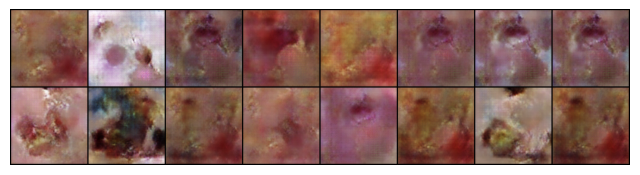

Epoch 191/200: 100%|██████████| 369/369 [00:37<00:00,  9.88it/s]


Epoch [191/200] | D Loss: 0.0019 | G Loss: -0.5624


Epoch 192/200: 100%|██████████| 369/369 [00:38<00:00,  9.63it/s]


Epoch [192/200] | D Loss: -0.0318 | G Loss: -0.5604


Epoch 193/200: 100%|██████████| 369/369 [00:37<00:00,  9.89it/s]


Epoch [193/200] | D Loss: -0.0053 | G Loss: -0.5580


Epoch 194/200: 100%|██████████| 369/369 [00:37<00:00,  9.76it/s]


Epoch [194/200] | D Loss: -0.0333 | G Loss: -0.4559


Epoch 195/200: 100%|██████████| 369/369 [00:37<00:00,  9.76it/s]


Epoch [195/200] | D Loss: -0.0312 | G Loss: -0.5203


Epoch 196/200: 100%|██████████| 369/369 [00:37<00:00,  9.84it/s]


Epoch [196/200] | D Loss: -0.0291 | G Loss: -0.5274


Epoch 197/200: 100%|██████████| 369/369 [00:36<00:00, 10.23it/s]


Epoch [197/200] | D Loss: -0.0805 | G Loss: -0.6350


Epoch 198/200: 100%|██████████| 369/369 [00:36<00:00, 10.03it/s]


Epoch [198/200] | D Loss: -0.0464 | G Loss: -0.4537


Epoch 199/200: 100%|██████████| 369/369 [00:36<00:00, 10.02it/s]


Epoch [199/200] | D Loss: -0.0159 | G Loss: -0.5033


Epoch 200/200: 100%|██████████| 369/369 [00:36<00:00, 10.00it/s]

Epoch [200/200] | D Loss: -0.0130 | G Loss: -0.5847


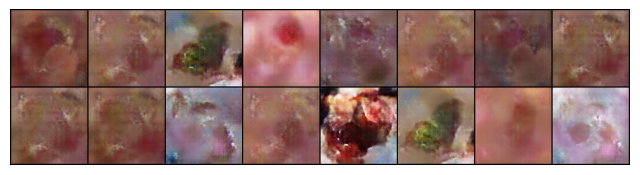

Training Complete! 🚀


In [ ]:

# ----------------------
# Training Loop
# ----------------------
latent_dim = 100
sequence_length = 10
lambda_gp = 10
critic_iter = 5
epochs = 200
save_dir = "./model_checkpoints"
os.makedirs(save_dir, exist_ok=True)

# Initialize Models
generator = HybridGenerator(latent_dim, sequence_length).to(device)
discriminator = Discriminator().to(device)

# Optimizers
g_optimizer = optim.Adam(generator.parameters(), lr=0.0001, betas=(0.5, 0.999))
d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0001, betas=(0.5, 0.999))

for epoch in range(epochs):
    for batch_idx, (real_imgs, _) in enumerate(tqdm(dataloader, desc=f"Epoch {epoch+1}/{epochs}")):
        real_imgs = real_imgs.to(device)
        batch_size = real_imgs.size(0)

        # Train Discriminator
        for _ in range(critic_iter):
            z = torch.randn(batch_size, sequence_length, latent_dim).to(device)
            fake_imgs = generator(z)

            d_real = discriminator(real_imgs)
            d_fake = discriminator(fake_imgs.detach())
            gp = gradient_penalty(discriminator, real_imgs, fake_imgs)

            d_loss = -torch.mean(d_real) + torch.mean(d_fake) + lambda_gp * gp

            d_optimizer.zero_grad()
            d_loss.backward()
            d_optimizer.step()

        # Train Generator
        z = torch.randn(batch_size, sequence_length, latent_dim).to(device)
        fake_imgs = generator(z)
        g_loss = -torch.mean(discriminator(fake_imgs))

        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()

    print(f"Epoch [{epoch+1}/{epochs}] | D Loss: {d_loss.item():.4f} | G Loss: {g_loss.item():.4f}")

    if (epoch + 1) % 10 == 0:
        with torch.no_grad():
            test_z = torch.randn(16, sequence_length, latent_dim).to(device)
            generated = generator(test_z)
            show_images(generated.cpu())

        # Save model checkpoints
        torch.save(generator.state_dict(), os.path.join(save_dir, f"generator_epoch_{epoch+1}.pth"))
        torch.save(discriminator.state_dict(), os.path.join(save_dir, f"discriminator_epoch_{epoch+1}.pth"))

print("Training Complete! 🚀")
